## Imports

In [1]:
from AGNCatalogToolbox import main as agn
from colossus.cosmology import cosmology
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dc_stat_think as dcst

In [2]:
# import data from IDL

from scipy.io import readsav
read_data = readsav('vars_EuclidAGN_90.sav',verbose=True)

data={}
for key, val in read_data.items():
    data[key]=np.copy(val)
    data[key][data[key] == 0.] = np.nan
print(data.keys())

--------------------------------------------------
Date: Sat Jun 27 11:54:09 2020
User: rcarraro
Host: stellarwind.local
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 8 records of which:
 - 1 are of type TIMESTAMP
 - 5 are of type VARIABLE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - m_ave [<class 'numpy.ndarray'>]
 - sfr_ave [<class 'numpy.ndarray'>]
 - l_ave [<class 'numpy.ndarray'>]
 - bhsf_ave [<class 'numpy.ndarray'>]
 - redshift [<class 'numpy.ndarray'>]
--------------------------------------------------
dict_keys(['m_ave', 'sfr_ave', 'l_ave', 'bhsf_ave', 'redshift'])


## Set cosmology

In [3]:
# my cosmology
params = {'flat': True, 'H0': 70., 'Om0': 0.3, 'Ob0': 0.0486, 'sigma8':0.8159, 'ns':0.9667}
cosmology.addCosmology('Carraro+20', params)

In [4]:
cosmo = 'Carraro+20'
cosmology = cosmology.setCosmology(cosmo)
volume = 200**3 # Mpc?

## Set universe parameters

In [21]:
z = 0.45
reds_dic={0.45:0, 1:1, 1.7:2, 2.7:3}
index=reds_dic.get(z) # needed for IDL data

methods={'halo_to_stars':'Moster' # 'Grylls19' or 'Moster'
    'BH_mass_method':"KormendyHo", #"Shankar16", "KormendyHo" and "Eq4"
    'BH_mass_scatter':"Intrinsic", # "Intrinsic" or float
    'duty_cycle':"Schulze", # "Schulze", "Schulze", "Geo" or float (0.18)
    'edd_ratio':"Schechter", # "Schechter", "PowerLaw", "Gaussian", "Geo"
    'bol_corr':'Lusso12_modif', # 'Duras20', 'Marconi04', 'Lusso12_modif'
    'SFR':'Carraro20' # 'Tomczak16', "Schreiber15", "Carraro20"
    }
print(methods['SFR'])

Carraro20


## Generate universe

In [22]:
gals = pd.DataFrame()

# Halos
gals['halos'] = agn.generate_semi_analytic_halo_catalogue(volume, [10, 16, 0.1], z, params.get('H0')/100)

# Galaxies
gals['stellar_mass'] = agn.halo_mass_to_stellar_mass(gals.halos, z, formula=methods['halo_to_stars'])

# BH
gals['black_hole_mass'] = agn.stellar_mass_to_black_hole_mass(gals.stellar_mass, method = methods['BH_mass_method'], 
                                                                                scatter = methods['BH_mass_scatter'])

Scatter is a thing, valued at 0.11
Warning - Kormendy and Ho's intrinsic scatter is effectively fixed, with a scale of 0.5


In [23]:
# Duty cycles
gals['duty_cycle'] = agn.to_duty_cycle(methods['duty_cycle'], gals.stellar_mass, gals.black_hole_mass, z)

Warning - we have requested redshift 0.45 - Selecting file Schulze_0.6.csv as it is closest
Warning - we have requested redshift 0.45 - Selecting file Schulze_0.6.csv as it is closest
GetCorrectFile: Schulze_0.6.csv
Found Schulze file: ./Data/DutyCycles/Schulze_0.6.csv
[6.13139835e-05 6.13139835e-05 6.13139835e-05 ... 1.02810239e-01
 1.02810239e-01 1.02810239e-01]


In [24]:
# Schechter parameters definition:

if methods['edd_ratio']=='Schechter' and methods['duty_cycle']=="Schulze" and methods['BH_mass_method']=="Shankar16":
    #fitting:
    #redshift = [0.1, 1, 2]
    #alpha = [-0.25,1.6,7.14]
    #lambd = [0.05, -0.8,-0.5]
    #alpha_pars=np.polyfit(redshift,alpha,2)
    #lambda_pars=np.polyfit(redshift,lambd,2)
    #np.savez('schechter_pars.npz',alpha_pars=alpha_pars,lambda_pars=lambda_pars)

    schechter_pars=np.load('schechter_pars.npz')
    alpha_pars=schechter_pars['alpha_pars']
    lambda_pars=schechter_pars['lambda_pars']

    alpha_pol=np.poly1d(alpha_pars)
    lambda_pol=np.poly1d(lambda_pars)

    alpha_z=alpha_pol(z)
    lambda_z=lambda_pol(z)

# già implementato nel fit qui sopra
# Schechter P(lambda), z=1, duty cycle di Schulze + 2015 usando la relazione Mstar-Mbh di Shankar + 16:
#lambda_z = -0.8
#alpha_z = 1.6

# Schechter P(lambda), z=1, duty cycle di Schulze + 2015 usando la relazione Mstar-Mbh di K&H +2013 :
if methods['edd_ratio']=='Schechter' and methods['duty_cycle']=="Schulze" and methods['BH_mass_method']=="KormendyHo":
    lambda_z = -0.4
    alpha_z = 0

# Schechter P(lambda), z=1, duty cycle costante e uguale a 0.18 usando la relazione Mstar-Mbh di Shankar + 16:
if z==1 and methods['edd_ratio']=='Schechter' and methods['duty_cycle']==0.18 and methods['BH_mass_method']=="Shankar16":
    lambda_z = -1
    alpha_z = 1.2

print(f'lambda_z={lambda_z}, alpha_z={alpha_z}')

lambda_z=-0.4, alpha_z=0


In [25]:
gals['luminosity'] = agn.black_hole_mass_to_luminosity(gals.black_hole_mass, gals.duty_cycle, gals.stellar_mass, z, methods['edd_ratio'],
                                        bol_corr=methods['bol_corr'], parameter1=lambda_z, parameter2=alpha_z)

In [26]:
gals['nh'] = agn.luminosity_to_nh(gals.luminosity, z)
gals['agn_type'] = agn.nh_to_type(gals.nh)

In [27]:
gals['SFR'] = agn.SFR(z,gals.stellar_mass,methods['SFR'])
gals['lx/SFR'] = (gals.luminosity-42)-gals.SFR

gals.describe()

,halos,stellar_mass,black_hole_mass,duty_cycle,luminosity,nh,agn_type,SFR,lx/SFR
count,3.498638e+06,3.498638e+06,3.498638e+06,3.498638e+06,3.498638e+06,3.498638e+06,3.498638e+06,3.498638e+06,3.498638e+06
mean,1.048691e+01,6.919219e+00,3.724269e+00,1.018889e-01,3.834457e+01,2.668800e+01,2.800049e+00,-2.355164e+00,-1.300269e+00
std,4.761596e-01,1.112391e+00,1.404735e+00,8.492432e-03,1.748307e+00,2.278000e+00,4.658116e-01,1.105886e+00,1.186740e+00
min,1.000000e+01,5.287492e+00,1.509081e-02,6.131398e-05,3.325911e+01,1.000000e+00,1.000000e+00,-4.599521e+00,-5.556884e+00
25%,1.014508e+01,6.094863e+00,2.738495e+00,1.028102e-01,3.708302e+01,2.510038e+01,3.000000e+00,-3.163216e+00,-2.207649e+00
50%,1.034198e+01,6.580702e+00,3.404311e+00,1.028102e-01,3.817172e+01,2.708219e+01,3.000000e+00,-2.669925e+00,-1.335843e+00
75%,1.067728e+01,7.409593e+00,4.391687e+00,1.028102e-01,3.935806e+01,2.854022e+01,3.000000e+00,-1.840800e+00,-4.248853e-01
max,1.487760e+01,1.226842e+01,1.090879e+01,1.028102e-01,4.640964e+01,2.999990e+01,3.000000e+00,2.051369e+00,3.278208e+00


In [28]:
# grouping in mass bins - log units
grouped_gals = gals[['stellar_mass','luminosity','SFR','lx/SFR']].groupby(pd.cut(gals.stellar_mass, np.append(np.arange(5, 11.5, 0.5),12.))).quantile([0.05,0.1585,0.5,0.8415,0.95]).unstack(level=1)

# converting to linear units
gals_lin=pd.DataFrame()
gals_lin['stellar_mass'] = gals['stellar_mass']
gals_lin['luminosity']= 10**(gals.luminosity-42)
gals_lin[['SFR','lx/SFR']]=10**gals[['SFR','lx/SFR']]

# grouping linear table
grouped_lin = gals_lin[['stellar_mass','luminosity','SFR','lx/SFR']].groupby(pd.cut(gals.stellar_mass, np.append(np.arange(5, 11.5, 0.5),12.))).quantile([0.05,0.1585,0.5,0.8415,0.95]).unstack(level=1)
# limit to logM>9
ggals_lin=grouped_lin[grouped_lin['stellar_mass',0.5] > 9]
grouped_lin.index.rename('mass_range',inplace=True)

### Bootstrapping

In [29]:
func=np.median

# create dataframe for bootstrapping
gals_highM=gals_lin.copy()[gals_lin.stellar_mass > 9]
grouped_linear = gals_highM[['stellar_mass','luminosity','SFR','lx/SFR']].groupby(pd.cut(gals_highM.stellar_mass, np.append(np.arange(9, 11.5, 0.5),12.)))#.quantile([0.05,0.1585,0.5,0.8415,0.95]).unstack(level=1)

# create dataframe of bootstraped linear varibles
gals_bs=pd.DataFrame()
gals_bs['SFR'] = grouped_linear.SFR.apply(lambda x: dcst.draw_bs_reps(x, func, size=500))
gals_bs['luminosity'] = grouped_linear.luminosity.apply(lambda x: dcst.draw_bs_reps(x, func, size=500))
gals_bs.head()

,SFR,luminosity
stellar_mass,,
"(9.0, 9.5]","[0.9243422460694906, 0.9241512701867725, 0.917...","[0.10781790117013307, 0.10841658762677261, 0.1..."
"(9.5, 10.0]","[2.870864754148203, 2.8823309836770474, 2.8757...","[0.411896788849398, 0.4230230544937596, 0.4349..."
"(10.0, 10.5]","[7.371444340568284, 7.36549507100269, 7.335940...","[2.8653258564147883, 2.8955571393066144, 2.746..."
"(10.5, 11.0]","[13.784244411933178, 13.856183023609027, 13.89...","[10.37554288347978, 10.811884583166906, 10.268..."
"(11.0, 12.0]","[19.03588472535324, 19.021605574652305, 18.916...","[31.600156935952672, 33.40416537114713, 33.329..."


In [30]:
# create dataframe with percentiles of the bootstrapped distribution
bs_perc=ggals_lin['stellar_mass']
old_idx = bs_perc.columns.to_frame()
perc_colnames=bs_perc.columns
old_idx.insert(0, '', 'stellar_mass')
bs_perc.columns = pd.MultiIndex.from_frame(old_idx)

bs_perc=bs_perc.join(pd.DataFrame(np.array([np.quantile(row,[0.05,0.1585,0.5,0.8415,0.95]) for row in gals_bs['SFR']]), 
                                  index=bs_perc.index, columns=pd.MultiIndex.from_product([['SFR'],perc_colnames])))
bs_perc=bs_perc.join(pd.DataFrame(np.array([np.quantile(row,[0.05,0.1585,0.5,0.8415,0.95]) for row in gals_bs['luminosity']]), 
                                  index=bs_perc.index, columns=pd.MultiIndex.from_product([['luminosity'],perc_colnames])))
bs_perc=bs_perc.join(pd.DataFrame(np.array([np.quantile(row['luminosity']/row['SFR'],[0.05,0.1585,0.5,0.8415,0.95]) for i,row in gals_bs.iterrows()]), 
                                  index=bs_perc.index, columns=pd.MultiIndex.from_product([['lx_SFR'],perc_colnames])))
#print(bs_perc)

### Plots

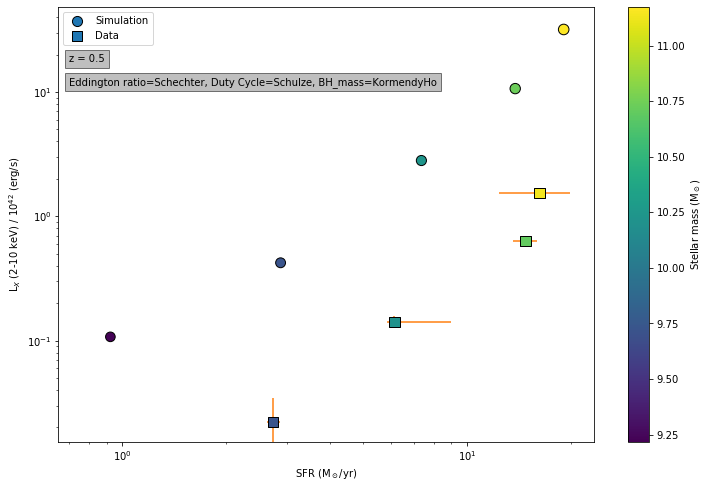

In [32]:
i=index

# define parameters for datapoints' colors and colorbar
_min = np.minimum(np.nanmin(bs_perc['stellar_mass',0.5]),np.nanmin(data['m_ave'][0,2:,:]))
_max = np.maximum(np.nanmax(bs_perc['stellar_mass',0.5]),np.nanmax(data['m_ave'][0,2:,:]))

# errorbars of bootstrapped simulation points
xerr=np.array([bs_perc['SFR',0.5] - bs_perc['SFR',0.05], 
              bs_perc['SFR',0.95] - bs_perc['SFR',0.5]])
yerr=np.array([bs_perc['luminosity',0.5] - bs_perc['luminosity',0.05], 
               bs_perc['luminosity',0.95] - bs_perc['luminosity',0.5]])

fig = plt.figure()
plt.rcParams['figure.figsize'] = [12, 8]

# simulated datapoints
plt.scatter(bs_perc['SFR',0.5],bs_perc['luminosity',0.5], vmin = _min, vmax = _max, edgecolors='Black',
            c=bs_perc['stellar_mass',0.5] , s=bs_perc['stellar_mass',0.5]*10, label='Simulation')
plt.errorbar(bs_perc['SFR',0.5],bs_perc['luminosity',0.5],
                xerr=xerr, yerr=yerr, linestyle='', zorder=0)

# "real" datapoints
sc=plt.scatter(data['sfr_ave'][0,2:,i], data['l_ave'][0,2:,i], vmin = _min, vmax = _max, edgecolors='Black',
            c=data['m_ave'][0,2:,0], s=data['m_ave'][0,2:,0]*10, marker="s",label='Data')
plt.errorbar(data['sfr_ave'][0,2:,i], data['l_ave'][0,2:,i],
                xerr=[data['sfr_ave'][0,2:,i]-data['sfr_ave'][2,2:,i],
                    data['sfr_ave'][1,2:,i]-data['sfr_ave'][0,2:,i]],
                yerr=np.array([data['l_ave'][0,2:,i] - data['l_ave'][2,2:,i], 
                    data['l_ave'][1,2:,i] - data['l_ave'][0,2:,i]]),
                linestyle='', zorder=0)

# colorbar, labels, legend, etc
plt.colorbar(sc).set_label('Stellar mass (M$_\odot$)')
plt.text(0.137, 0.79, f'z = {z:.1f}', horizontalalignment='left',
          verticalalignment='center', bbox=dict(facecolor='gray', alpha=0.5), transform=fig.transFigure)
plt.text(0.137, 0.75, f"Halo to M* = {methods['halo_to_stars']}, Eddington ratio = {methods['edd_ratio']}, Duty Cycle = {methods['duty_cycle']}, BH_mass = {methods['BH_mass_method']}", 
        horizontalalignment='left', verticalalignment='center', bbox=dict(facecolor='gray', alpha=0.5), transform=fig.transFigure)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('SFR (M$_\odot$/yr)')
plt.ylabel('L$_X$ (2-10 keV) / $10^{42}$ (erg/s)')
plt.legend(loc='upper left');
curr_dir=os.getcwd()
plt.savefig(curr_dir+f'/Ros_plots/SFvsLX_z{z}.pdf', format = 'pdf', bbox_inches = 'tight',transparent=True) 

In [33]:
print(data['sfr_ave'][0,2:,i], data['l_ave'][0,2:,i])

[ 0.91180036  2.7328649   6.15547289 14.76535132 16.21676045] [-5.75867754e-05  2.20478023e-02  1.41606145e-01  6.34796619e-01
  1.53561555e+00]
